In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import os
import json
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
import warnings
import missingno
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load data
df = pd.read_csv('./Dataset/UNSW_NB15_training-set.csv')

# Display basic information about the dataset
print(df.info())
print(df.head())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

<Axes: >

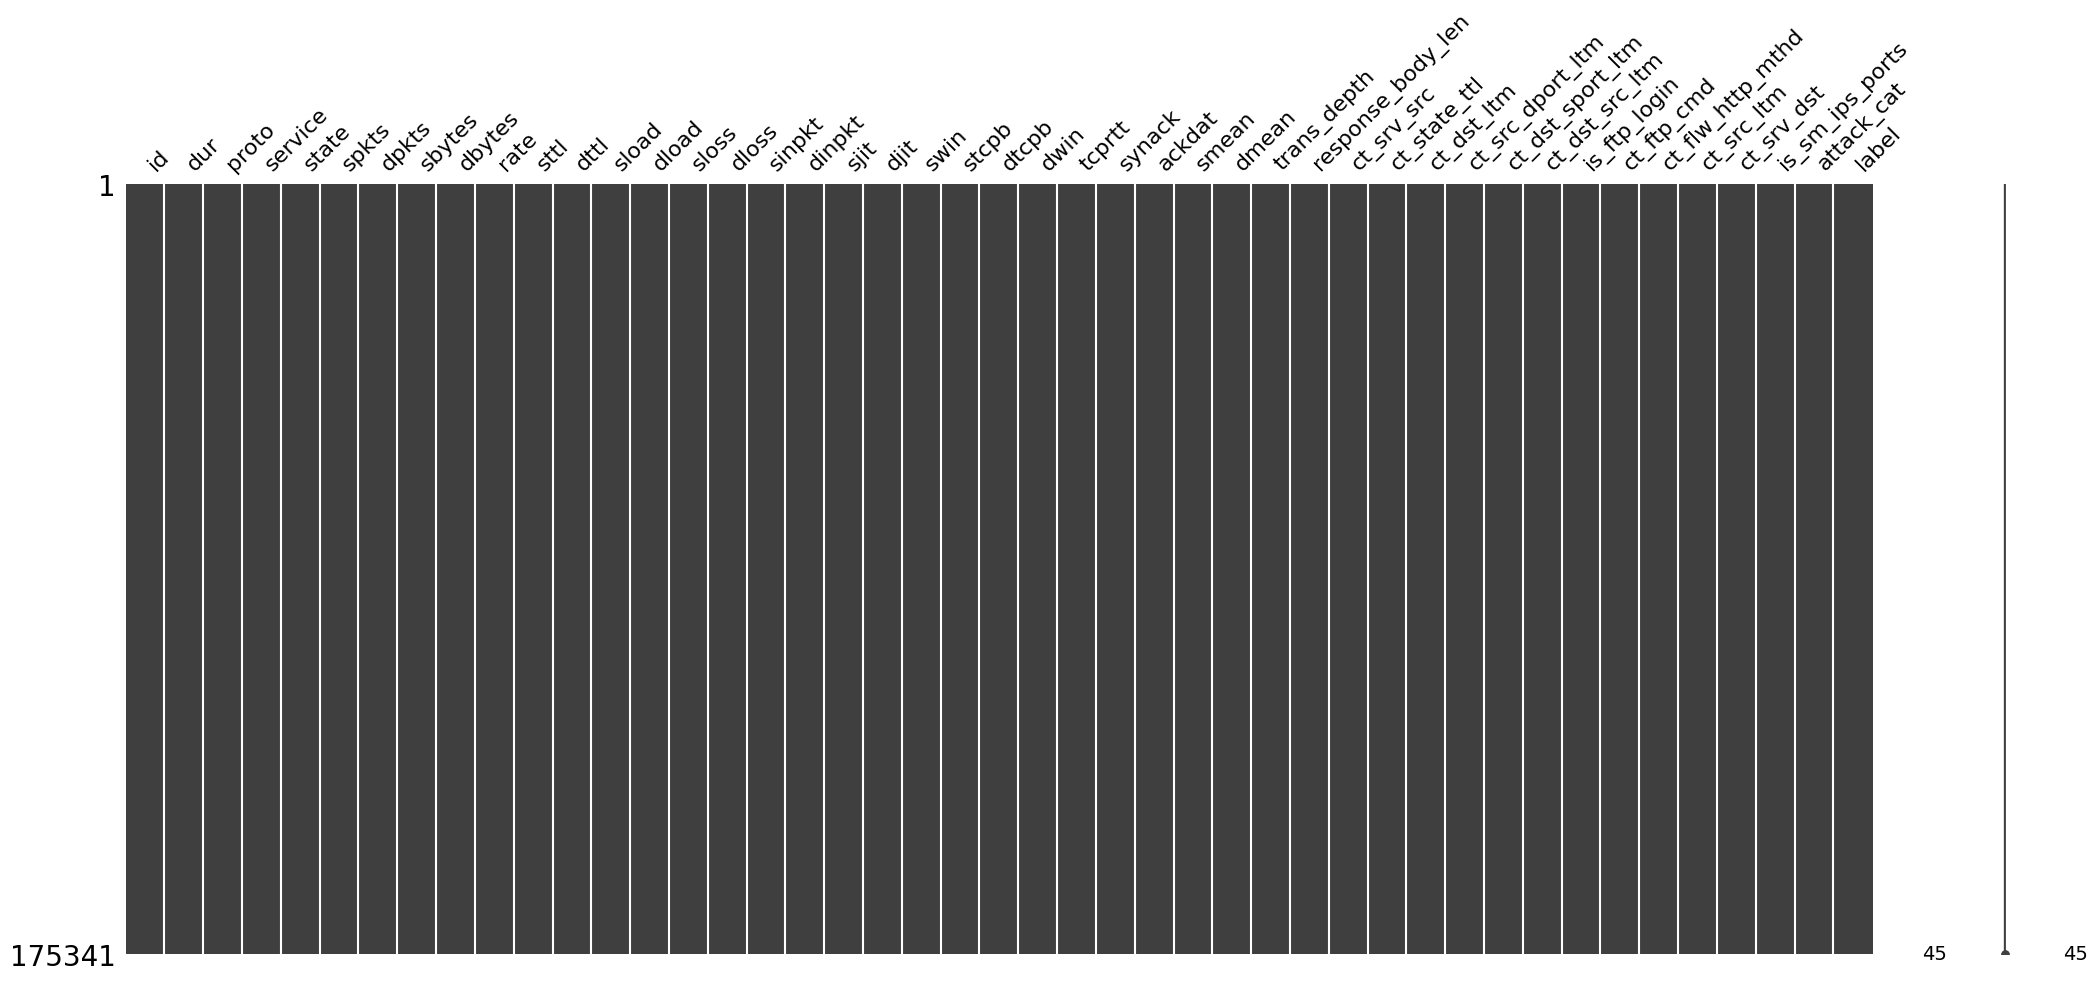

In [3]:
missingno.matrix(df)

In [4]:
# Define feature modalities
MODALITIES = {
    'flow_features': [
        'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate',
        'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss'
    ],
    'time_features': [
        'sinpkt', 'dinpkt', 'sjit', 'djit'
    ],
    'window_features': [
        'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat'
    ],
    'packet_features': [
        'smean', 'dmean'
    ],
    'connection_features': [
        'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl',
        'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'
    ],
    'protocol_features': [
        'proto', 'service', 'state'
    ],
    'ftp_features': [
        'is_ftp_login', 'ct_ftp_cmd'
    ],
    'http_features': [
        'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'
    ]
}

In [5]:
# Convert binary labels
df['label'] = df['label'].map({0: 'Normal', 1: 'Ransomware'})

# Split data into training and temporary sets (70:30)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Split temporary data into validation and testing sets (50:50)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [6]:
# Preprocess the dataset by modality
def preprocess_modalities(df: pd.DataFrame) -> Tuple[Dict[str, np.ndarray], np.ndarray]:
    processed_data = {}

    # Process each modality separately
    for modality, features in MODALITIES.items():
        # Get features for current modality
        modal_data = df[features].copy()

        # Handle categorical features
        categorical_cols = modal_data.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            le = LabelEncoder()
            modal_data[col] = le.fit_transform(modal_data[col].astype(str))

        # Normalize numerical features
        scaler = MinMaxScaler()
        processed_data[modality] = scaler.fit_transform(modal_data)

    # Process labels
    le_labels = LabelEncoder()
    labels = le_labels.fit_transform(df['label'])

    return processed_data, labels

# Process training data by modality
processed_train_data, train_labels = preprocess_modalities(train_df)

# Process validation data by modality
processed_val_data, val_labels = preprocess_modalities(val_df)

# Process test data by modality
processed_test_data, test_labels = preprocess_modalities(test_df)

# Print class distribution
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 39228, 1: 83510}


In [7]:
# Menyimpan data training
train_df.to_csv('./Result/train_data_imbalance.csv', index=False)

# Menyimpan data validation
val_df.to_csv('./Result/val_data_imbalance.csv', index=False)

# Menyimpan data testing
test_df.to_csv('./Result/test_data_imbalance.csv', index=False)

In [7]:
# Create a custom dataset class for multi-modal data
class MultiModalDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor], labels: torch.Tensor):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.data.items()}, self.labels[idx]

# Define a modality encoder class
class ModalityEncoder(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.encoder(x)

# Define the multi-modal transformer model
class MultiModalTransformer(nn.Module):
    def __init__(self, modality_dims: Dict[str, int], fusion_dim: int = 128):
        super().__init__()

        # Create encoders for each modality
        self.encoders = nn.ModuleDict({
            modality: ModalityEncoder(dim, fusion_dim)
            for modality, dim in modality_dims.items()
        })

        # Multi-head attention for fusion
        self.fusion_attention = nn.MultiheadAttention(
            fusion_dim, num_heads=4, dropout=0.1
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(fusion_dim // 2, 2)  # Binary classification
        )

    def forward(self, modalities: Dict[str, torch.Tensor]):
        # Encode each modality
        encoded_features = []
        for modality, features in modalities.items():
            encoded = self.encoders[modality](features)
            encoded_features.append(encoded)

        # Stack encoded features
        stacked_features = torch.stack(encoded_features, dim=0)

        # Apply self-attention for fusion
        fused_features, _ = self.fusion_attention(
            stacked_features, stacked_features, stacked_features
        )

        # Average pooling across modalities
        fused_features = torch.mean(fused_features, dim=0)

        # Classification
        return self.classifier(fused_features)

In [8]:
# Define the training function for one epoch
def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Tuple[float, float]:
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_data, labels in tqdm(train_loader, desc="Training", leave=False):
        # Move data to device
        batch_data = {
            modality: features.to(device).float()
            for modality, features in batch_data.items()
        }
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(train_loader), correct / total

In [9]:
# Define the validation function
def validate(model: nn.Module,
             val_loader: DataLoader,
             criterion: nn.Module,
             device: torch.device) -> Tuple[float, float, List[int], List[float]]:
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch_data, labels in tqdm(val_loader, desc="Validating", leave=False):
            # Move data to device
            batch_data = {
                modality: features.to(device).float()
                for modality, features in batch_data.items()
            }
            labels = labels.to(device)

            outputs = model(batch_data)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

    return total_loss / len(val_loader), correct / total, all_labels, all_preds, all_probs


In [10]:
# Define a class to handle model checkpoints
class ModelCheckpoint:
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.best_val_acc = 0

    def save_checkpoint(self, model: nn.Module, val_acc: float, fold: int, epoch: int):
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'val_accuracy': val_acc,
                'fold': fold,
                'epoch': epoch,
                'timestamp': datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            }
            os.makedirs(os.path.dirname(self.filepath), exist_ok=True)
            torch.save(checkpoint, self.filepath)
            return True
        return False

# Define a class to handle training history
class TrainingHistory:
    def __init__(self):
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'fold_metrics': {}
        }

    def update(self, fold: int, epoch: int, metrics: Dict):
        if fold not in self.history['fold_metrics']:
            self.history['fold_metrics'][fold] = []

        self.history['fold_metrics'][fold].append({
            'epoch': epoch + 1,  # Adjust epoch to start from 1
            **metrics
        })

    def plot_metrics(self, fold: int):
        metrics = pd.DataFrame(self.history['fold_metrics'][fold])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(metrics['epoch'], metrics['train_loss'], label='Training Loss')
        ax1.plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss')
        ax1.set_title(f'Model Loss - Fold {fold + 1}')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Accuracy plot
        ax2.plot(metrics['epoch'], metrics['train_acc'], label='Training Accuracy')
        ax2.plot(metrics['epoch'], metrics['val_acc'], label='Validation Accuracy')
        ax2.set_title(f'Model Accuracy - Fold {fold + 1}')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, fold: int):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def print_classification_report(self, y_true, y_pred, fold: int):
        print(f"\nClassification Report - Fold {fold + 1}")
        print(classification_report(y_true, y_pred))

In [12]:
# Define the training function with k-fold cross-validation
def train_model_with_kfold(
    model: nn.Module,
    dataset: Dataset,
    n_splits: int = 5,
    num_epochs: int = 30,
    batch_size: int = 32,
    device: torch.device = device
) -> Tuple[nn.Module, TrainingHistory]:

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    criterion = nn.CrossEntropyLoss()
    history = TrainingHistory()
    checkpoint = ModelCheckpoint('models/best_model_imbalance.pth')

    best_fold_metrics = {
        'fold': -1,
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1': 0,
        'specificity': 0,
        'roc_auc': 0
    }

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold + 1}/{n_splits}")
        print("-" * 40)

        # Create data loaders for this fold
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=train_subsampler
        )
        val_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=val_subsampler
        )

        # Reset model for each fold
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            # Training
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer, device
            )

            # Validation
            val_loss, val_acc, val_labels, val_preds, val_probs = validate(
                model, val_loader, criterion, device
            )

            # Update history
            history.update(fold, epoch, {
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc
            })

            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
            print("-" * 40)

            # Save checkpoint if best model
            checkpoint.save_checkpoint(model, val_acc, fold, epoch)

        # Calculate final metrics for this fold
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for batch_data, labels in tqdm(val_loader, desc=f"Evaluating Fold {fold + 1}", leave=False):
                batch_data = {k: v.to(device).float() for k, v in batch_data.items()}
                outputs = model(batch_data)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        accuracy = accuracy_score(all_labels, all_preds)
        specificity = confusion_matrix(all_labels, all_preds)[0, 0] / (confusion_matrix(all_labels, all_preds)[0, 0] + confusion_matrix(all_labels, all_preds)[0, 1])
        roc_auc = roc_auc_score(all_labels, all_probs)

        # Update best fold metrics
        if accuracy > best_fold_metrics['accuracy']:
            best_fold_metrics.update({
                'fold': fold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'specificity': specificity,
                'roc_auc': roc_auc
            })

        # Plot fold results
        history.plot_metrics(fold)
        history.plot_confusion_matrix(all_labels, all_preds, fold)
        history.print_classification_report(all_labels, all_preds, fold)

    # Print final report
    print("\nFinal Report")
    print("=" * 40)
    print(f"Best Fold: {best_fold_metrics['fold'] + 1}")
    print(f"Best Accuracy: {best_fold_metrics['accuracy']:.4f}")
    print(f"Best Precision: {best_fold_metrics['precision']:.4f}")
    print(f"Best Recall: {best_fold_metrics['recall']:.4f}")
    print(f"Best F1 Score: {best_fold_metrics['f1']:.4f}")
    print(f"Best Specificity: {best_fold_metrics['specificity']:.4f}")
    print(f"Best ROC-AUC: {best_fold_metrics['roc_auc']:.4f}")

    return model, history


Fold 1/5
----------------------------------------


Epoch 1/30
Train Loss: 0.1600 - Train Acc: 0.9325 - Val Loss: 0.1394 - Val Acc: 0.9384
----------------------------------------


Epoch 2/30
Train Loss: 0.1399 - Train Acc: 0.9358 - Val Loss: 0.1474 - Val Acc: 0.9381
----------------------------------------


Epoch 3/30
Train Loss: 0.1353 - Train Acc: 0.9365 - Val Loss: 0.1344 - Val Acc: 0.9384
----------------------------------------


Epoch 4/30
Train Loss: 0.1344 - Train Acc: 0.9374 - Val Loss: 0.1262 - Val Acc: 0.9401
----------------------------------------


Epoch 5/30
Train Loss: 0.1306 - Train Acc: 0.9387 - Val Loss: 0.1237 - Val Acc: 0.9424
----------------------------------------


Epoch 6/30
Train Loss: 0.1294 - Train Acc: 0.9385 - Val Loss: 0.1319 - Val Acc: 0.9369
----------------------------------------


Epoch 7/30
Train Loss: 0.1285 - Train Acc: 0.9400 - Val Loss: 0.1317 - Val Acc: 0.9422
----------------------------------------


Epoch 8/30
Train Loss: 0.1260 - Train Acc: 0.9391 - Val Loss: 0.1203 - Val Acc: 0.9396
----------------------------------------


Epoch 9/30
Train Loss: 0.1243 - Train Acc: 0.9406 - Val Loss: 0.1186 - Val Acc: 0.9428
----------------------------------------


Epoch 10/30
Train Loss: 0.1213 - Train Acc: 0.9397 - Val Loss: 0.1146 - Val Acc: 0.9426
----------------------------------------


Epoch 11/30
Train Loss: 0.1207 - Train Acc: 0.9401 - Val Loss: 0.1155 - Val Acc: 0.9433
----------------------------------------


Epoch 12/30
Train Loss: 0.1185 - Train Acc: 0.9407 - Val Loss: 0.1128 - Val Acc: 0.9440
----------------------------------------


Epoch 13/30
Train Loss: 0.1186 - Train Acc: 0.9408 - Val Loss: 0.1141 - Val Acc: 0.9435
----------------------------------------


Epoch 14/30
Train Loss: 0.1173 - Train Acc: 0.9410 - Val Loss: 0.1141 - Val Acc: 0.9433
----------------------------------------


Epoch 15/30
Train Loss: 0.1172 - Train Acc: 0.9413 - Val Loss: 0.1130 - Val Acc: 0.9431
----------------------------------------


Epoch 16/30
Train Loss: 0.1167 - Train Acc: 0.9413 - Val Loss: 0.1138 - Val Acc: 0.9435
----------------------------------------


Epoch 17/30
Train Loss: 0.1167 - Train Acc: 0.9416 - Val Loss: 0.1172 - Val Acc: 0.9450
----------------------------------------


Epoch 18/30
Train Loss: 0.1163 - Train Acc: 0.9418 - Val Loss: 0.1129 - Val Acc: 0.9446
----------------------------------------


Epoch 19/30
Train Loss: 0.1159 - Train Acc: 0.9417 - Val Loss: 0.1138 - Val Acc: 0.9434
----------------------------------------


Epoch 20/30
Train Loss: 0.1160 - Train Acc: 0.9418 - Val Loss: 0.1107 - Val Acc: 0.9442
----------------------------------------


Epoch 21/30
Train Loss: 0.1152 - Train Acc: 0.9423 - Val Loss: 0.1111 - Val Acc: 0.9442
----------------------------------------


Epoch 22/30
Train Loss: 0.1152 - Train Acc: 0.9415 - Val Loss: 0.1124 - Val Acc: 0.9439
----------------------------------------


Epoch 23/30
Train Loss: 0.1145 - Train Acc: 0.9426 - Val Loss: 0.1106 - Val Acc: 0.9455
----------------------------------------


Epoch 24/30
Train Loss: 0.1148 - Train Acc: 0.9428 - Val Loss: 0.1120 - Val Acc: 0.9439
----------------------------------------


Epoch 25/30
Train Loss: 0.1145 - Train Acc: 0.9422 - Val Loss: 0.1099 - Val Acc: 0.9436
----------------------------------------


Epoch 26/30
Train Loss: 0.1141 - Train Acc: 0.9430 - Val Loss: 0.1097 - Val Acc: 0.9445
----------------------------------------


Epoch 27/30
Train Loss: 0.1137 - Train Acc: 0.9426 - Val Loss: 0.1112 - Val Acc: 0.9464
----------------------------------------


Epoch 28/30
Train Loss: 0.1138 - Train Acc: 0.9430 - Val Loss: 0.1119 - Val Acc: 0.9404
----------------------------------------


Epoch 29/30
Train Loss: 0.1141 - Train Acc: 0.9420 - Val Loss: 0.1099 - Val Acc: 0.9453
----------------------------------------


Epoch 30/30
Train Loss: 0.1142 - Train Acc: 0.9421 - Val Loss: 0.1109 - Val Acc: 0.9442
----------------------------------------


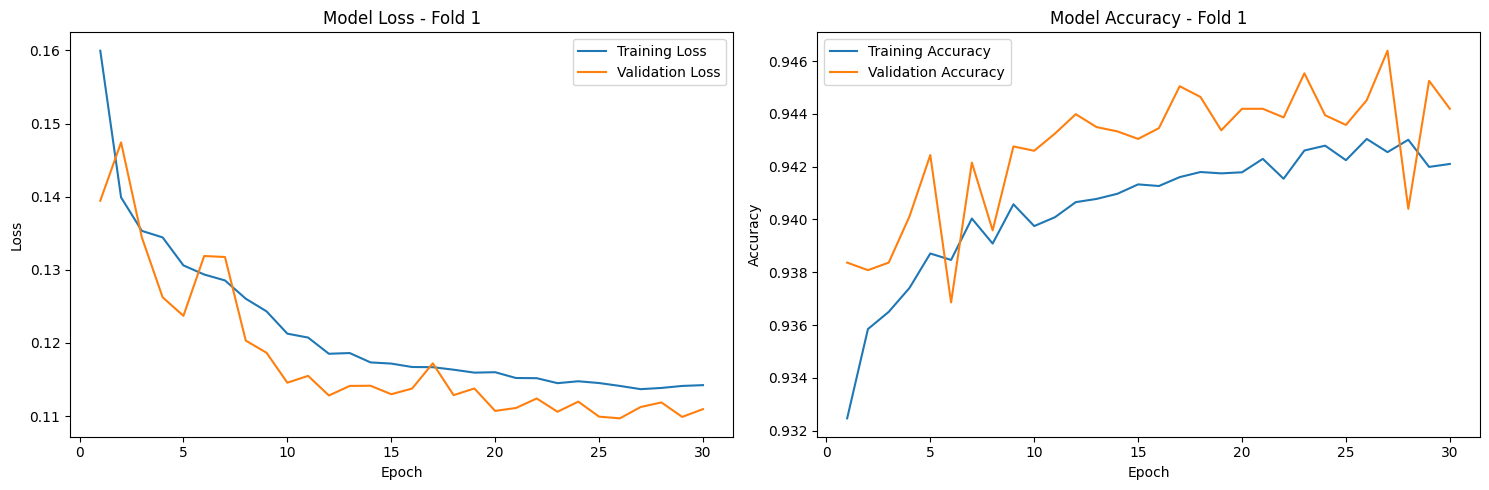

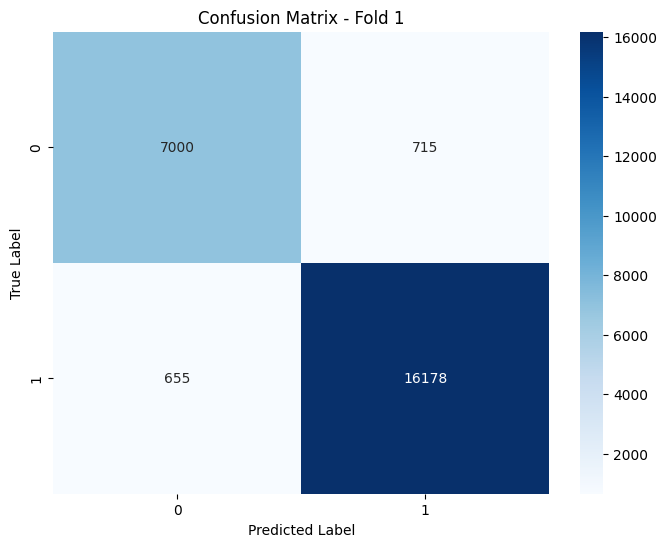


Classification Report - Fold 1
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      7715
           1       0.96      0.96      0.96     16833

    accuracy                           0.94     24548
   macro avg       0.94      0.93      0.94     24548
weighted avg       0.94      0.94      0.94     24548


Fold 2/5
----------------------------------------


Epoch 1/30
Train Loss: 0.1810 - Train Acc: 0.9282 - Val Loss: 0.1375 - Val Acc: 0.9400
----------------------------------------


Epoch 2/30
Train Loss: 0.1471 - Train Acc: 0.9334 - Val Loss: 0.1335 - Val Acc: 0.9400
----------------------------------------


Epoch 3/30
Train Loss: 0.1437 - Train Acc: 0.9343 - Val Loss: 0.1332 - Val Acc: 0.9411
----------------------------------------


Epoch 4/30
Train Loss: 0.1420 - Train Acc: 0.9348 - Val Loss: 0.1322 - Val Acc: 0.9409
----------------------------------------


Epoch 5/30
Train Loss: 0.1410 - Train Acc: 0.9347 - Val Loss: 0.1268 - Val Acc: 0.9422
----------------------------------------


Epoch 6/30
Train Loss: 0.1395 - Train Acc: 0.9353 - Val Loss: 0.1267 - Val Acc: 0.9409
----------------------------------------


Epoch 7/30
Train Loss: 0.1381 - Train Acc: 0.9353 - Val Loss: 0.1244 - Val Acc: 0.9426
----------------------------------------


Epoch 8/30
Train Loss: 0.1365 - Train Acc: 0.9357 - Val Loss: 0.1240 - Val Acc: 0.9416
----------------------------------------


Epoch 9/30
Train Loss: 0.1361 - Train Acc: 0.9361 - Val Loss: 0.1317 - Val Acc: 0.9420
----------------------------------------


Epoch 10/30
Train Loss: 0.1349 - Train Acc: 0.9356 - Val Loss: 0.1291 - Val Acc: 0.9411
----------------------------------------


Epoch 11/30
Train Loss: 0.1351 - Train Acc: 0.9363 - Val Loss: 0.1258 - Val Acc: 0.9427
----------------------------------------


Epoch 12/30
Train Loss: 0.1335 - Train Acc: 0.9361 - Val Loss: 0.1219 - Val Acc: 0.9433
----------------------------------------


Epoch 13/30
Train Loss: 0.1328 - Train Acc: 0.9367 - Val Loss: 0.1222 - Val Acc: 0.9424
----------------------------------------


Epoch 14/30
Train Loss: 0.1307 - Train Acc: 0.9365 - Val Loss: 0.1199 - Val Acc: 0.9423
----------------------------------------


Epoch 15/30
Train Loss: 0.1302 - Train Acc: 0.9370 - Val Loss: 0.1211 - Val Acc: 0.9439
----------------------------------------


Epoch 16/30
Train Loss: 0.1293 - Train Acc: 0.9368 - Val Loss: 0.1159 - Val Acc: 0.9434
----------------------------------------


Epoch 17/30
Train Loss: 0.1280 - Train Acc: 0.9373 - Val Loss: 0.1179 - Val Acc: 0.9426
----------------------------------------


Epoch 18/30
Train Loss: 0.1271 - Train Acc: 0.9375 - Val Loss: 0.1180 - Val Acc: 0.9419
----------------------------------------


Epoch 19/30
Train Loss: 0.1268 - Train Acc: 0.9379 - Val Loss: 0.1220 - Val Acc: 0.9407
----------------------------------------


Epoch 20/30
Train Loss: 0.1255 - Train Acc: 0.9389 - Val Loss: 0.1178 - Val Acc: 0.9393
----------------------------------------


Epoch 21/30
Train Loss: 0.1245 - Train Acc: 0.9387 - Val Loss: 0.1121 - Val Acc: 0.9435
----------------------------------------


Epoch 22/30
Train Loss: 0.1230 - Train Acc: 0.9398 - Val Loss: 0.1227 - Val Acc: 0.9428
----------------------------------------


Epoch 23/30
Train Loss: 0.1217 - Train Acc: 0.9405 - Val Loss: 0.1106 - Val Acc: 0.9451
----------------------------------------


Epoch 24/30
Train Loss: 0.1208 - Train Acc: 0.9405 - Val Loss: 0.1132 - Val Acc: 0.9432
----------------------------------------


Epoch 25/30
Train Loss: 0.1212 - Train Acc: 0.9408 - Val Loss: 0.1117 - Val Acc: 0.9434
----------------------------------------


Epoch 26/30
Train Loss: 0.1214 - Train Acc: 0.9404 - Val Loss: 0.1152 - Val Acc: 0.9422
----------------------------------------


Epoch 27/30
Train Loss: 0.1198 - Train Acc: 0.9402 - Val Loss: 0.1092 - Val Acc: 0.9449
----------------------------------------


Epoch 28/30
Train Loss: 0.1198 - Train Acc: 0.9400 - Val Loss: 0.1094 - Val Acc: 0.9451
----------------------------------------


Epoch 29/30
Train Loss: 0.1190 - Train Acc: 0.9405 - Val Loss: 0.1128 - Val Acc: 0.9446
----------------------------------------


Epoch 30/30
Train Loss: 0.1190 - Train Acc: 0.9417 - Val Loss: 0.1077 - Val Acc: 0.9450
----------------------------------------


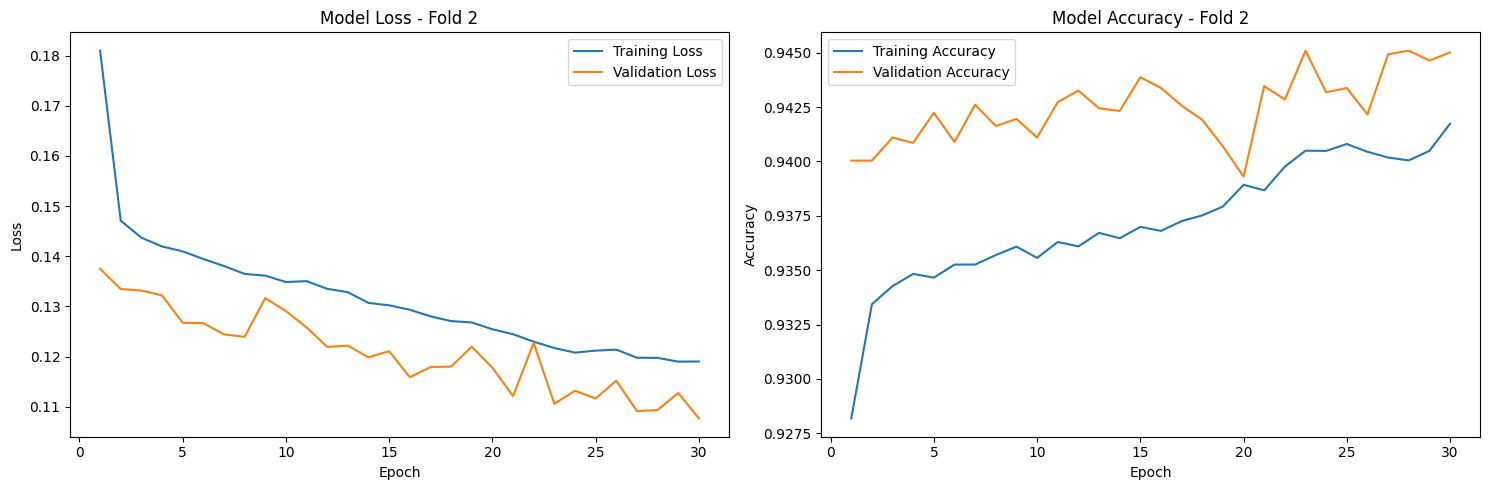

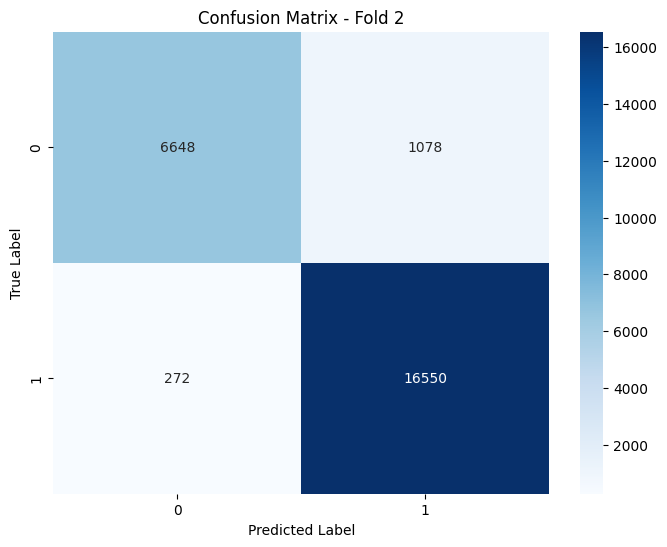


Classification Report - Fold 2
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      7726
           1       0.94      0.98      0.96     16822

    accuracy                           0.95     24548
   macro avg       0.95      0.92      0.93     24548
weighted avg       0.95      0.95      0.94     24548


Fold 3/5
----------------------------------------


Epoch 1/30
Train Loss: 0.1753 - Train Acc: 0.9295 - Val Loss: 0.1486 - Val Acc: 0.9334
----------------------------------------


Epoch 2/30
Train Loss: 0.1481 - Train Acc: 0.9343 - Val Loss: 0.1488 - Val Acc: 0.9340
----------------------------------------


Epoch 3/30
Train Loss: 0.1425 - Train Acc: 0.9346 - Val Loss: 0.1339 - Val Acc: 0.9351
----------------------------------------


Epoch 4/30
Train Loss: 0.1396 - Train Acc: 0.9356 - Val Loss: 0.1299 - Val Acc: 0.9387
----------------------------------------


Epoch 5/30
Train Loss: 0.1343 - Train Acc: 0.9373 - Val Loss: 0.1241 - Val Acc: 0.9391
----------------------------------------


Epoch 6/30
Train Loss: 0.1303 - Train Acc: 0.9376 - Val Loss: 0.1223 - Val Acc: 0.9382
----------------------------------------


Epoch 7/30
Train Loss: 0.1281 - Train Acc: 0.9381 - Val Loss: 0.1228 - Val Acc: 0.9402
----------------------------------------


Epoch 8/30
Train Loss: 0.1260 - Train Acc: 0.9385 - Val Loss: 0.1189 - Val Acc: 0.9421
----------------------------------------


Epoch 9/30
Train Loss: 0.1261 - Train Acc: 0.9380 - Val Loss: 0.1202 - Val Acc: 0.9391
----------------------------------------


Epoch 10/30
Train Loss: 0.1245 - Train Acc: 0.9390 - Val Loss: 0.1180 - Val Acc: 0.9421
----------------------------------------


Epoch 11/30
Train Loss: 0.1241 - Train Acc: 0.9402 - Val Loss: 0.1193 - Val Acc: 0.9428
----------------------------------------


Epoch 12/30
Train Loss: 0.1231 - Train Acc: 0.9401 - Val Loss: 0.1182 - Val Acc: 0.9406
----------------------------------------


Epoch 13/30
Train Loss: 0.1232 - Train Acc: 0.9402 - Val Loss: 0.1139 - Val Acc: 0.9437
----------------------------------------


Epoch 14/30
Train Loss: 0.1219 - Train Acc: 0.9402 - Val Loss: 0.1254 - Val Acc: 0.9421
----------------------------------------


Epoch 15/30
Train Loss: 0.1215 - Train Acc: 0.9399 - Val Loss: 0.1156 - Val Acc: 0.9416
----------------------------------------


Epoch 16/30
Train Loss: 0.1213 - Train Acc: 0.9403 - Val Loss: 0.1167 - Val Acc: 0.9432
----------------------------------------


Epoch 17/30
Train Loss: 0.1212 - Train Acc: 0.9403 - Val Loss: 0.1165 - Val Acc: 0.9441
----------------------------------------


Epoch 18/30
Train Loss: 0.1208 - Train Acc: 0.9409 - Val Loss: 0.1141 - Val Acc: 0.9428
----------------------------------------


Epoch 19/30
Train Loss: 0.1202 - Train Acc: 0.9404 - Val Loss: 0.1143 - Val Acc: 0.9374
----------------------------------------


Epoch 20/30
Train Loss: 0.1191 - Train Acc: 0.9407 - Val Loss: 0.1160 - Val Acc: 0.9419
----------------------------------------


Epoch 21/30
Train Loss: 0.1186 - Train Acc: 0.9410 - Val Loss: 0.1155 - Val Acc: 0.9437
----------------------------------------


Epoch 22/30
Train Loss: 0.1190 - Train Acc: 0.9414 - Val Loss: 0.1154 - Val Acc: 0.9447
----------------------------------------


Epoch 23/30
Train Loss: 0.1184 - Train Acc: 0.9409 - Val Loss: 0.1127 - Val Acc: 0.9447
----------------------------------------


Epoch 24/30
Train Loss: 0.1189 - Train Acc: 0.9414 - Val Loss: 0.1148 - Val Acc: 0.9418
----------------------------------------


Epoch 25/30
Train Loss: 0.1181 - Train Acc: 0.9419 - Val Loss: 0.1114 - Val Acc: 0.9442
----------------------------------------


Epoch 26/30
Train Loss: 0.1173 - Train Acc: 0.9419 - Val Loss: 0.1133 - Val Acc: 0.9433
----------------------------------------


Epoch 27/30
Train Loss: 0.1171 - Train Acc: 0.9417 - Val Loss: 0.1123 - Val Acc: 0.9438
----------------------------------------


Epoch 28/30
Train Loss: 0.1164 - Train Acc: 0.9420 - Val Loss: 0.1138 - Val Acc: 0.9401
----------------------------------------


Epoch 29/30
Train Loss: 0.1169 - Train Acc: 0.9419 - Val Loss: 0.1207 - Val Acc: 0.9435
----------------------------------------


Epoch 30/30
Train Loss: 0.1174 - Train Acc: 0.9420 - Val Loss: 0.1160 - Val Acc: 0.9446
----------------------------------------


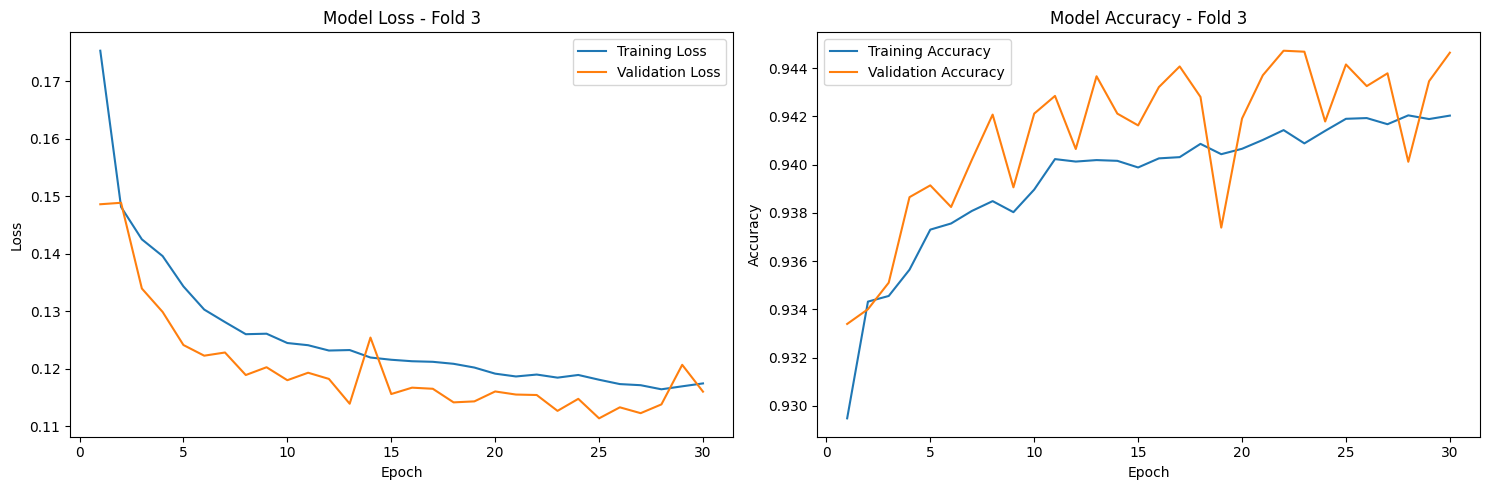

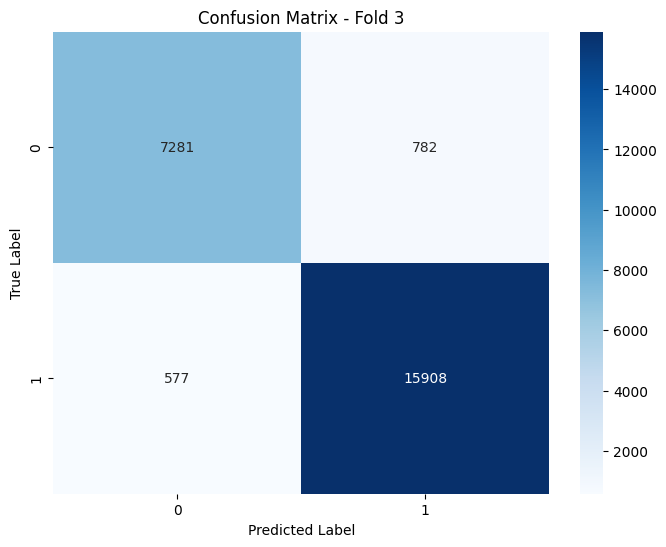


Classification Report - Fold 3
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      8063
           1       0.95      0.96      0.96     16485

    accuracy                           0.94     24548
   macro avg       0.94      0.93      0.94     24548
weighted avg       0.94      0.94      0.94     24548


Fold 4/5
----------------------------------------


Epoch 1/30
Train Loss: 0.1792 - Train Acc: 0.9269 - Val Loss: 0.1442 - Val Acc: 0.9335
----------------------------------------


Epoch 2/30
Train Loss: 0.1455 - Train Acc: 0.9355 - Val Loss: 0.1346 - Val Acc: 0.9364
----------------------------------------


Epoch 3/30
Train Loss: 0.1405 - Train Acc: 0.9366 - Val Loss: 0.1348 - Val Acc: 0.9353
----------------------------------------


Epoch 4/30
Train Loss: 0.1378 - Train Acc: 0.9368 - Val Loss: 0.1468 - Val Acc: 0.9342
----------------------------------------


Epoch 5/30
Train Loss: 0.1377 - Train Acc: 0.9372 - Val Loss: 0.1320 - Val Acc: 0.9369
----------------------------------------


Epoch 6/30
Train Loss: 0.1355 - Train Acc: 0.9375 - Val Loss: 0.1385 - Val Acc: 0.9353
----------------------------------------


Epoch 7/30
Train Loss: 0.1343 - Train Acc: 0.9373 - Val Loss: 0.1323 - Val Acc: 0.9354
----------------------------------------


Epoch 8/30
Train Loss: 0.1337 - Train Acc: 0.9370 - Val Loss: 0.1406 - Val Acc: 0.9349
----------------------------------------


Epoch 9/30
Train Loss: 0.1319 - Train Acc: 0.9381 - Val Loss: 0.1279 - Val Acc: 0.9378
----------------------------------------


Epoch 10/30
Train Loss: 0.1314 - Train Acc: 0.9384 - Val Loss: 0.1263 - Val Acc: 0.9377
----------------------------------------


Epoch 11/30
Train Loss: 0.1303 - Train Acc: 0.9387 - Val Loss: 0.1261 - Val Acc: 0.9386
----------------------------------------


Epoch 12/30
Train Loss: 0.1296 - Train Acc: 0.9383 - Val Loss: 0.1246 - Val Acc: 0.9387
----------------------------------------


Epoch 13/30
Train Loss: 0.1292 - Train Acc: 0.9387 - Val Loss: 0.1239 - Val Acc: 0.9378
----------------------------------------


Epoch 14/30
Train Loss: 0.1285 - Train Acc: 0.9383 - Val Loss: 0.1247 - Val Acc: 0.9393
----------------------------------------


Epoch 15/30
Train Loss: 0.1284 - Train Acc: 0.9380 - Val Loss: 0.1236 - Val Acc: 0.9415
----------------------------------------


Epoch 16/30
Train Loss: 0.1261 - Train Acc: 0.9392 - Val Loss: 0.1190 - Val Acc: 0.9404
----------------------------------------


Epoch 17/30
Train Loss: 0.1255 - Train Acc: 0.9395 - Val Loss: 0.1223 - Val Acc: 0.9387
----------------------------------------


Epoch 18/30
Train Loss: 0.1245 - Train Acc: 0.9400 - Val Loss: 0.1229 - Val Acc: 0.9424
----------------------------------------


Epoch 19/30
Train Loss: 0.1223 - Train Acc: 0.9400 - Val Loss: 0.1208 - Val Acc: 0.9375
----------------------------------------


Epoch 20/30
Train Loss: 0.1213 - Train Acc: 0.9403 - Val Loss: 0.1215 - Val Acc: 0.9392
----------------------------------------


Epoch 21/30
Train Loss: 0.1223 - Train Acc: 0.9401 - Val Loss: 0.1176 - Val Acc: 0.9423
----------------------------------------


Epoch 22/30
Train Loss: 0.1202 - Train Acc: 0.9404 - Val Loss: 0.1159 - Val Acc: 0.9431
----------------------------------------


Epoch 23/30
Train Loss: 0.1199 - Train Acc: 0.9405 - Val Loss: 0.1145 - Val Acc: 0.9386
----------------------------------------


Epoch 24/30
Train Loss: 0.1189 - Train Acc: 0.9408 - Val Loss: 0.1177 - Val Acc: 0.9383
----------------------------------------


Epoch 25/30
Train Loss: 0.1177 - Train Acc: 0.9418 - Val Loss: 0.1157 - Val Acc: 0.9411
----------------------------------------


Epoch 26/30
Train Loss: 0.1192 - Train Acc: 0.9415 - Val Loss: 0.1169 - Val Acc: 0.9374
----------------------------------------


Epoch 27/30
Train Loss: 0.1171 - Train Acc: 0.9409 - Val Loss: 0.1138 - Val Acc: 0.9396
----------------------------------------


Epoch 28/30
Train Loss: 0.1181 - Train Acc: 0.9413 - Val Loss: 0.1133 - Val Acc: 0.9438
----------------------------------------


Epoch 29/30
Train Loss: 0.1166 - Train Acc: 0.9412 - Val Loss: 0.1153 - Val Acc: 0.9448
----------------------------------------


Epoch 30/30
Train Loss: 0.1166 - Train Acc: 0.9424 - Val Loss: 0.1175 - Val Acc: 0.9417
----------------------------------------


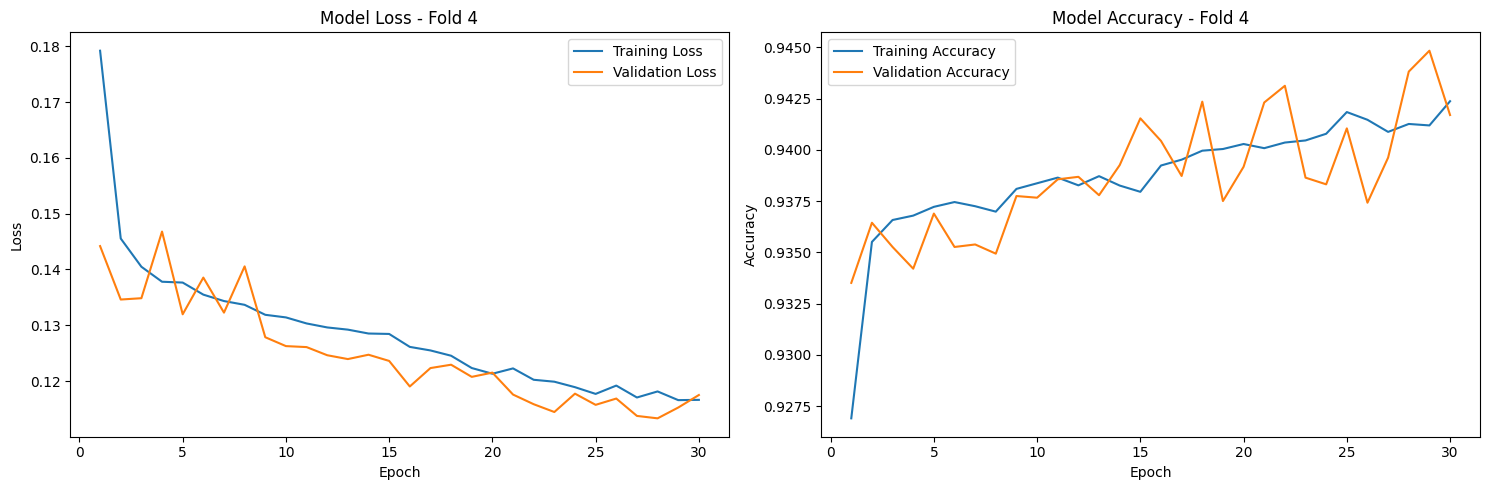

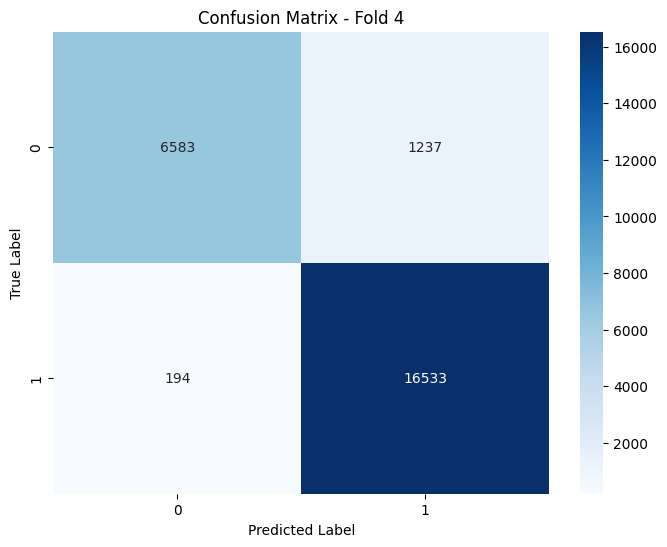


Classification Report - Fold 4
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      7820
           1       0.93      0.99      0.96     16727

    accuracy                           0.94     24547
   macro avg       0.95      0.92      0.93     24547
weighted avg       0.94      0.94      0.94     24547


Fold 5/5
----------------------------------------


Epoch 1/30
Train Loss: 0.1680 - Train Acc: 0.9327 - Val Loss: 0.1537 - Val Acc: 0.9301
----------------------------------------


Epoch 2/30
Train Loss: 0.1432 - Train Acc: 0.9365 - Val Loss: 0.1474 - Val Acc: 0.9301
----------------------------------------


Epoch 3/30
Train Loss: 0.1379 - Train Acc: 0.9370 - Val Loss: 0.1381 - Val Acc: 0.9336
----------------------------------------


Epoch 4/30
Train Loss: 0.1357 - Train Acc: 0.9374 - Val Loss: 0.1390 - Val Acc: 0.9321
----------------------------------------


Epoch 5/30
Train Loss: 0.1352 - Train Acc: 0.9372 - Val Loss: 0.1512 - Val Acc: 0.9342
----------------------------------------


Epoch 6/30
Train Loss: 0.1331 - Train Acc: 0.9384 - Val Loss: 0.1428 - Val Acc: 0.9326
----------------------------------------


Epoch 7/30
Train Loss: 0.1335 - Train Acc: 0.9382 - Val Loss: 0.1358 - Val Acc: 0.9345
----------------------------------------


Epoch 8/30
Train Loss: 0.1320 - Train Acc: 0.9378 - Val Loss: 0.1351 - Val Acc: 0.9348
----------------------------------------


Epoch 9/30
Train Loss: 0.1311 - Train Acc: 0.9382 - Val Loss: 0.1356 - Val Acc: 0.9344
----------------------------------------


Epoch 10/30
Train Loss: 0.1308 - Train Acc: 0.9387 - Val Loss: 0.1330 - Val Acc: 0.9340
----------------------------------------


Epoch 11/30
Train Loss: 0.1279 - Train Acc: 0.9390 - Val Loss: 0.1358 - Val Acc: 0.9331
----------------------------------------


Epoch 12/30
Train Loss: 0.1280 - Train Acc: 0.9389 - Val Loss: 0.1330 - Val Acc: 0.9335
----------------------------------------


Epoch 13/30
Train Loss: 0.1276 - Train Acc: 0.9390 - Val Loss: 0.1331 - Val Acc: 0.9340
----------------------------------------


Epoch 14/30
Train Loss: 0.1266 - Train Acc: 0.9390 - Val Loss: 0.1408 - Val Acc: 0.9353
----------------------------------------


Epoch 15/30
Train Loss: 0.1257 - Train Acc: 0.9397 - Val Loss: 0.1352 - Val Acc: 0.9347
----------------------------------------


Epoch 16/30
Train Loss: 0.1250 - Train Acc: 0.9401 - Val Loss: 0.1347 - Val Acc: 0.9321
----------------------------------------


Epoch 17/30
Train Loss: 0.1249 - Train Acc: 0.9397 - Val Loss: 0.1295 - Val Acc: 0.9364
----------------------------------------


Epoch 18/30
Train Loss: 0.1250 - Train Acc: 0.9405 - Val Loss: 0.1306 - Val Acc: 0.9349
----------------------------------------


Epoch 19/30
Train Loss: 0.1234 - Train Acc: 0.9401 - Val Loss: 0.1281 - Val Acc: 0.9339
----------------------------------------


Epoch 20/30
Train Loss: 0.1230 - Train Acc: 0.9408 - Val Loss: 0.1398 - Val Acc: 0.9353
----------------------------------------


Epoch 21/30
Train Loss: 0.1217 - Train Acc: 0.9417 - Val Loss: 0.1263 - Val Acc: 0.9364
----------------------------------------


Epoch 22/30
Train Loss: 0.1216 - Train Acc: 0.9418 - Val Loss: 0.1279 - Val Acc: 0.9380
----------------------------------------


Epoch 23/30
Train Loss: 0.1203 - Train Acc: 0.9421 - Val Loss: 0.1312 - Val Acc: 0.9386
----------------------------------------


Epoch 24/30
Train Loss: 0.1209 - Train Acc: 0.9415 - Val Loss: 0.1376 - Val Acc: 0.9358
----------------------------------------


Epoch 25/30
Train Loss: 0.1200 - Train Acc: 0.9425 - Val Loss: 0.1284 - Val Acc: 0.9405
----------------------------------------


Epoch 26/30
Train Loss: 0.1193 - Train Acc: 0.9427 - Val Loss: 0.1292 - Val Acc: 0.9375
----------------------------------------


Epoch 27/30
Train Loss: 0.1195 - Train Acc: 0.9421 - Val Loss: 0.1290 - Val Acc: 0.9356
----------------------------------------


Epoch 28/30
Train Loss: 0.1188 - Train Acc: 0.9421 - Val Loss: 0.1231 - Val Acc: 0.9384
----------------------------------------


Epoch 29/30
Train Loss: 0.1188 - Train Acc: 0.9426 - Val Loss: 0.1253 - Val Acc: 0.9387
----------------------------------------


Epoch 30/30
Train Loss: 0.1189 - Train Acc: 0.9431 - Val Loss: 0.1242 - Val Acc: 0.9393
----------------------------------------


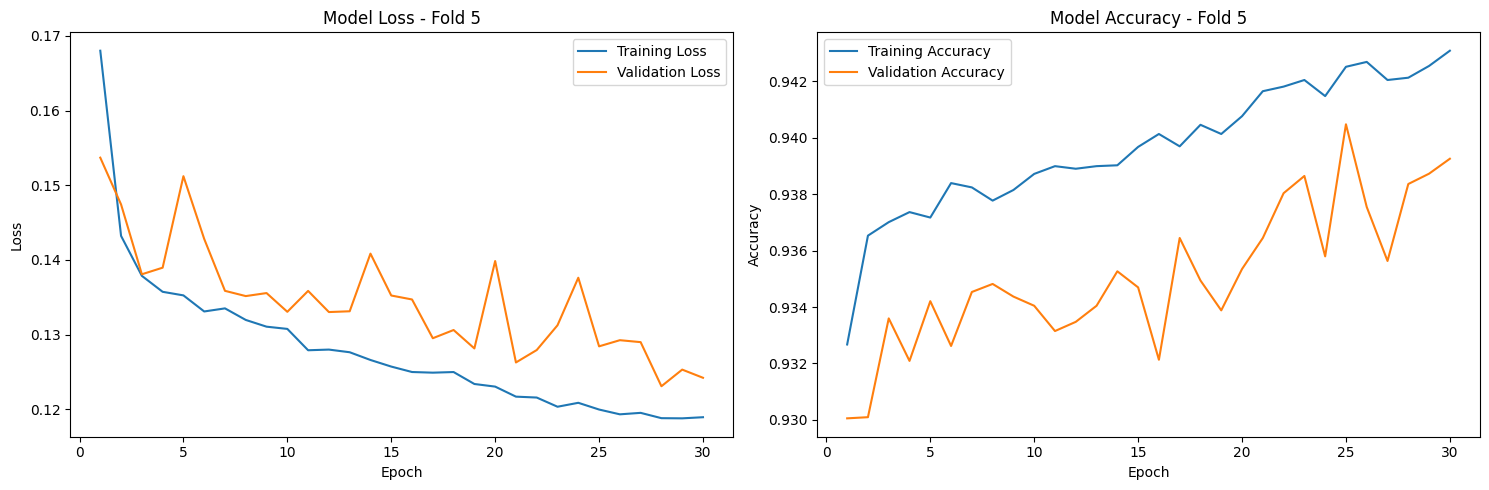

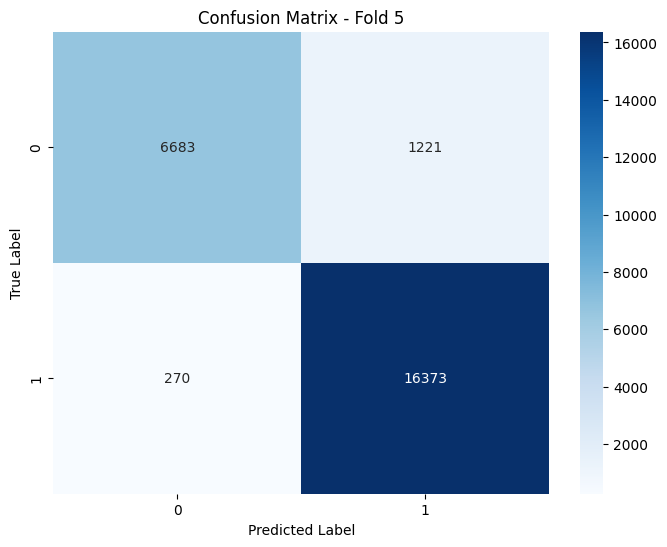


Classification Report - Fold 5
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      7904
           1       0.93      0.98      0.96     16643

    accuracy                           0.94     24547
   macro avg       0.95      0.91      0.93     24547
weighted avg       0.94      0.94      0.94     24547


Final Report
Best Fold: 2
Best Accuracy: 0.9450
Best Precision: 0.9457
Best Recall: 0.9450
Best F1 Score: 0.9441
Best Specificity: 0.8605
Best ROC-AUC: 0.9902


In [13]:
# Calculate dimensions for each modality
modality_dims = {
    modality: data.shape[1]
    for modality, data in processed_train_data.items()
}

# Create model
model = MultiModalTransformer(modality_dims).to(device)

# Convert training data to tensors
tensor_train_data = {
    modality: torch.FloatTensor(data)
    for modality, data in processed_train_data.items()
}
tensor_train_labels = torch.LongTensor(train_labels)

# Create dataset
train_dataset = MultiModalDataset(tensor_train_data, tensor_train_labels)

# Train model with k-fold cross validation
model, history = train_model_with_kfold(
    model, train_dataset, n_splits=5, num_epochs=30
)


Test Evaluation Results
Test Loss: 0.1473
Test Accuracy: 0.9386
Test Precision: 0.9401
Test Recall: 0.9386
Test F1 Score: 0.9374
Test Specificity: 0.8374
Test ROC-AUC: 0.9833


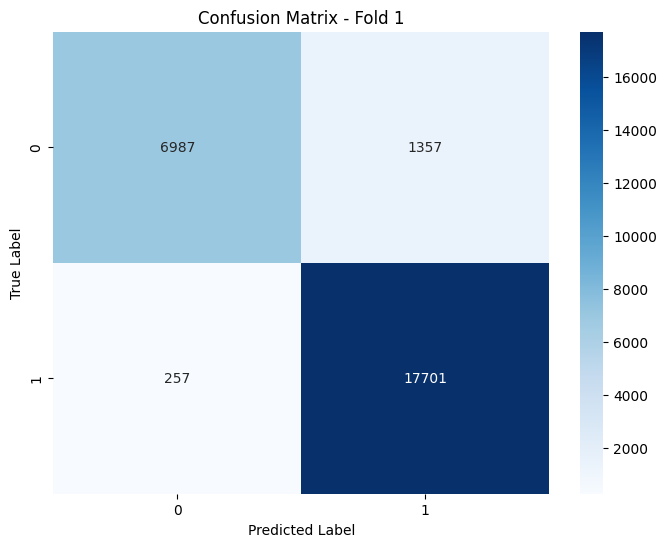


Classification Report - Fold 1
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      8344
           1       0.93      0.99      0.96     17958

    accuracy                           0.94     26302
   macro avg       0.95      0.91      0.93     26302
weighted avg       0.94      0.94      0.94     26302



In [15]:
# Convert test data to tensors
tensor_test_data = {
    modality: torch.FloatTensor(data)
    for modality, data in processed_test_data.items()
}
tensor_test_labels = torch.LongTensor(test_labels)

# Create test dataset
test_dataset = MultiModalDataset(tensor_test_data, tensor_test_labels)

# Create data loaders for validation and test datasets
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test set
test_loss, test_acc, test_labels, test_preds, test_probs = validate(model, test_loader, nn.CrossEntropyLoss(), device)

# Print test metrics
print("\nTest Evaluation Results")
print("=" * 40)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Calculate additional test metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
specificity = confusion_matrix(test_labels, test_preds)[0, 0] / (confusion_matrix(test_labels, test_preds)[0, 0] + confusion_matrix(test_labels, test_preds)[0, 1])
roc_auc = roc_auc_score(test_labels, test_probs)

# Print additional test metrics
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Specificity: {specificity:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")

# Plot confusion matrix
history.plot_confusion_matrix(test_labels, test_preds, fold=1)

# Print classification report
history.print_classification_report(test_labels, test_preds, fold=1)